### Motivation

We found a dataset regarding parking occupancy by Copenhagen Kommune.This dataset includes the number of parked vehicles during three specific time slots, namely 12:00, 17:00, and 22:00, on one selected day in March and October for each year from 2012 to 2020. The parking occupancy rate is obtained by dividing the counted number of parked vehicles by the total number of parking spaces.  

We have chosen this dataset because it offers more comprehensive information compared to other parking-related datasets. It meets our research objectives as it includes data on the number of parked vehicles, the total number of parking spaces, and additional information.The comprehensive nature of the included information provides greater potential for conducting in-depth analysis in the subsequent stages.  

We hope that after completing our study, people will have a clear understanding of which areas in Copenhagen are easy to find parking spaces during different time slots and which areas are more challenging. Additionally, we aim to provide valuable recommendations for future urban management.

### Basic stats

In the original data, we removed the rows with invalid/null values ​​under the three time point columns, changed the format of the time column to datetime and normalized the format of the wkb_geometry column so that we can use it for the place labeling of the interactive map. ‘count_new’ has 30,505 pieces of data containing street geographic information in the ten years from 2012 to 2022, including 1,509 roads. The following is the column explanation we used:  

"FID":   
This is a unique identifier for each row in the dataset.  

"vejnavn":   
This is the name of the street where the parking spot is located.   

"lovlig_p_kl_12"/"lovlig_p_kl_17"/"lovlig_p_kl_22":   
This is the number of legal parking spots at 12:00 pm,05:00 pm and 10:00 pm.  

"parkerede_biler_kl_12"/"parkerede_biler_kl_17"/"parkerede_biler_kl_22":   
This is the number of parked cars at 12:00 pm,05:00 pm and 10:00 pm.  

"belaegning_kl_12_pct"/"belaegning_kl_17_pct"/"belaegning_kl_22_pct":   
This is the percentage of occupied parking spots at 12:00 pm,05:00 pm and 10:00 pm.  

"aar_mdr":   
This is the year and month of the observation.  

"wkb_geometry":   
This is the geometry of the parking spot in WKB format.  

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import colorsys
import folium
import ipywidgets as widgets
from IPython.display import display, clear_output
count_new=pd.read_csv('new_parking_count.csv')
count_new.head()

,FID,pkey,taelle_id,vejnavn,straekning,lovlig_p_kl_12,parkerede_biler_kl_12,belaegning_kl_12_pct,lovlig_p_kl_17,parkerede_biler_kl_17,...,kategori,aar_mdr,vej_id,fra_m,til_m,id,ogc_fid,wkb_geometry,sum_columns,District
0,taelling_p_pladser.fid--38345ac2_187759ec53d_65f5,5,2,Dyrkøb,NaN,37,48.0,130.0,37,33.0,...,NaN,201709.0,1.0114E+12,0.0,115.0,1,5,MULTILINESTRING ((12.573769564824445 55.679320...,481.0,City_center
1,taelling_p_pladser.fid--38345ac2_187759ec53d_65f6,6,2,Dyrkøb,NaN,41,44.0,107.0,41,40.0,...,NaN,201409.0,1.0114E+12,0.0,115.0,1,6,MULTILINESTRING ((12.573769564824445 55.679320...,532.0,City_center
2,taelling_p_pladser.fid--38345ac2_187759ec53d_65f7,7,2,Dyrkøb,NaN,43,46.0,107.0,43,43.0,...,NaN,201203.0,1.0114E+12,0.0,115.0,1,7,MULTILINESTRING ((12.573769564824445 55.679320...,521.0,City_center
3,taelling_p_pladser.fid--38345ac2_187759ec53d_65f8,8,2,Dyrkøb,NaN,30,33.0,110.0,30,27.0,...,NaN,202209.0,1.0114E+12,0.0,115.0,1,8,MULTILINESTRING ((12.573769564824445 55.679320...,463.0,City_center
4,taelling_p_pladser.fid--38345ac2_187759ec53d_65f9,9,2,Dyrkøb,NaN,41,44.0,107.0,41,44.0,...,NaN,201403.0,1.0114E+12,0.0,115.0,1,9,MULTILINESTRING ((12.573769564824445 55.679320...,552.0,City_center


### Data Analysis

In order to predict the available parking spaces at different times, we analyzed the occupancy rate in the dataframe, because we believe that the severity of illegal parking spaces can represent the local traffic volume to a certain extent. First, we collected the street names of all neighborhoods in Copenhagen, corresponding to the street name "vejnavn" column of its original data set, and added the "District" column. In terms of value, we counted the number of illegal parking every year, and were surprised to find that the average was as high as 80,720, an increase of nearly 240% in 2022/2023 compared to 10 years ago.

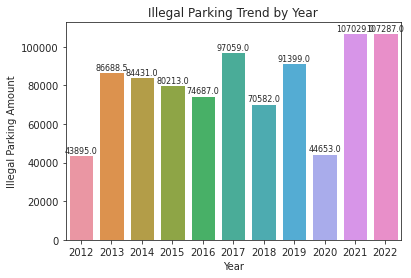

In [13]:
# Convert the datetime column to datetime type
count_new['arr_mdr'] = pd.to_datetime(count_new['aar_mdr'], format='%Y%m')
count_new['year'] = count_new['arr_mdr'].dt.year

def calc_diff(row, col1, col2):
    if row[col2] > row[col1]:
        return row[col2] - row[col1]
    else:
        return pd.NA  # skip if col2 is not over col1

# apply the function to create a new column 'diff1'
count_new['diff1'] = count_new.apply(calc_diff, args=('parkerede_biler_kl_12', 'lovlig_p_kl_12'), axis=1)
count_new['diff2'] = count_new.apply(calc_diff, args=('parkerede_biler_kl_17', 'lovlig_p_kl_17'), axis=1)
count_new['diff3'] = count_new.apply(calc_diff, args=('parkerede_biler_kl_22', 'lovlig_p_kl_22'), axis=1)
count_new['illegal_num'] = count_new['diff1'] + count_new['diff2'] + count_new['diff3']

count_new = count_new.dropna(subset=['year'])# drop missing value
df_grouped = count_new.groupby('year')['illegal_num'].sum().reset_index()

# Convert the 'year' column to integer type
df_grouped['year'] = df_grouped['year'].astype(int)

sns.set_style('ticks')
sns.barplot(data=df_grouped, x='year', y='illegal_num')


for i, v in enumerate(df_grouped['illegal_num']):#Add annotations
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=8)

plt.xlabel('Year')
plt.ylabel('Illegal Parking Amount')
plt.title('Illegal Parking Trend by Year')

# Show the plot
plt.show()


For spatial analysis, we compared and analyzed the differences in occupancy rates in geographical locations through the district corresponding to the street name in three time periods, 12:00, 15:00 and 22:00. Over time, the three most varied districts are "Valby", "Vesterbro/Kongens Enghave" and "City center". Geographically they are central and adjacent in Copenhagen. As the occupancy rate of "City center" and "Valby" decreased, that of "Vesterbro/Kongens Enghave" increased instead. We infer this phenomenon is because more people work in "City center" and "Valby" but more Stay more in "Vesterbro/Kongens Enghave".

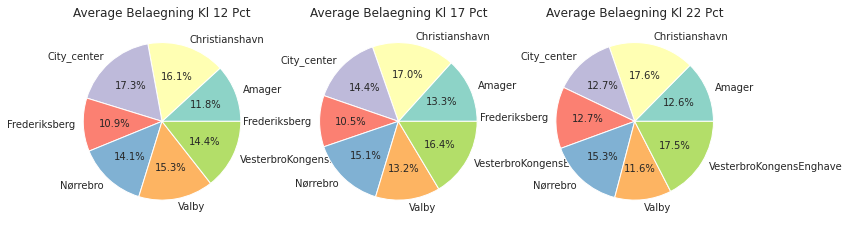

In [14]:
colors = plt.cm.Set3(range(7))

# Create the three pie charts
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

# belaegning_kl_12_pct
belaegning_12_pct = count_new.groupby('District')['belaegning_kl_12_pct'].mean()
ax[0].pie(belaegning_12_pct, colors=colors, labels=belaegning_12_pct.index, autopct='%1.1f%%')
ax[0].set_title('Average Belaegning Kl 12 Pct')

# belaegning_kl_17_pct
belaegning_17_pct = count_new.groupby('District')['belaegning_kl_17_pct'].mean()
ax[1].pie(belaegning_17_pct, colors=colors, labels=belaegning_17_pct.index, autopct='%1.1f%%')
ax[1].set_title('Average Belaegning Kl 17 Pct')

# belaegning_kl_22_pct
belaegning_22_pct = count_new.groupby('District')['belaegning_kl_22_pct'].mean()
ax[2].pie(belaegning_22_pct, colors=colors, labels=belaegning_22_pct.index, autopct='%1.1f%%')
ax[2].set_title('Average Belaegning Kl 22 Pct')

plt.show()

### Genre

For Visual Narrative 


1.   close-ups:focus the reader's attention on a specific point.
2.   feature distinction:When creating visual graphics, differentiating data using different colors enables readers to quickly obtain relevant and effective information.
3.   consistent visual perform:It ensures clear information and enhances the reader's reading experience.  

For Narrative Structure 


1.   linear: The article has a complete structure and logical coherence.
2.   captions: They attract readers while summarizing the main theme of the article.
3.   introductory text: Readers can quickly grasp the content of the article.
4.   summary: It provides a concise overview of the content, saving readers' reading time.


### Visualization

1. We choose the heat map to visually reflect the parking occupancy rate of each district. Areas with annotations over 100 means that there are basically no parking spaces or even illegal occupation of many parking spaces, which will affect the normal operation of traffic and drivers shoule avoid these congested areas. "Cristianshavn" and "Vesterbro/Kongens Enghave" are basically crowded all day long, but "Citycenter" is particularly prominent in the morning rush hour.

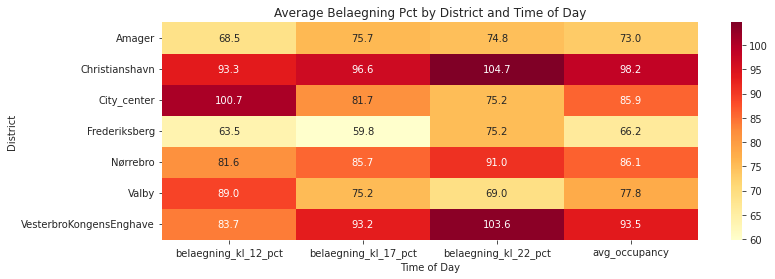

In [15]:
# Calculate the mean values by district for the three time periods
belaegning_by_district = count_new.groupby('District')[['belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_22_pct']].mean()
belaegning_by_district['avg_occupancy'] = belaegning_by_district.mean(axis=1)
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(belaegning_by_district, cmap='YlOrRd', annot=True, fmt='.1f', ax=ax)

# Set the axis labels and title
ax.set_xlabel('Time of Day')
ax.set_ylabel('District')
ax.set_title('Average Belaegning Pct by District and Time of Day')

plt.show()

2. For most workers who need to commute, the morning rush hour is the time period with the highest demand for parking spaces. "City_center" is the area with the highest occupancy rate in the morning peak. We drew a scatterplot of the occupancy rate of each street in three periods and obtained a line chart of the average occupancy level of their parking lots. From the figure, we selected the 5 streets that are most likely to get parking spaces during the morning peak hours: "Silkegade", "Sankt Pauls Plads", "Haregade", "Gammeltorv", "Klarebodeme". (Average and morning peak occupancy rates are both below 50%)

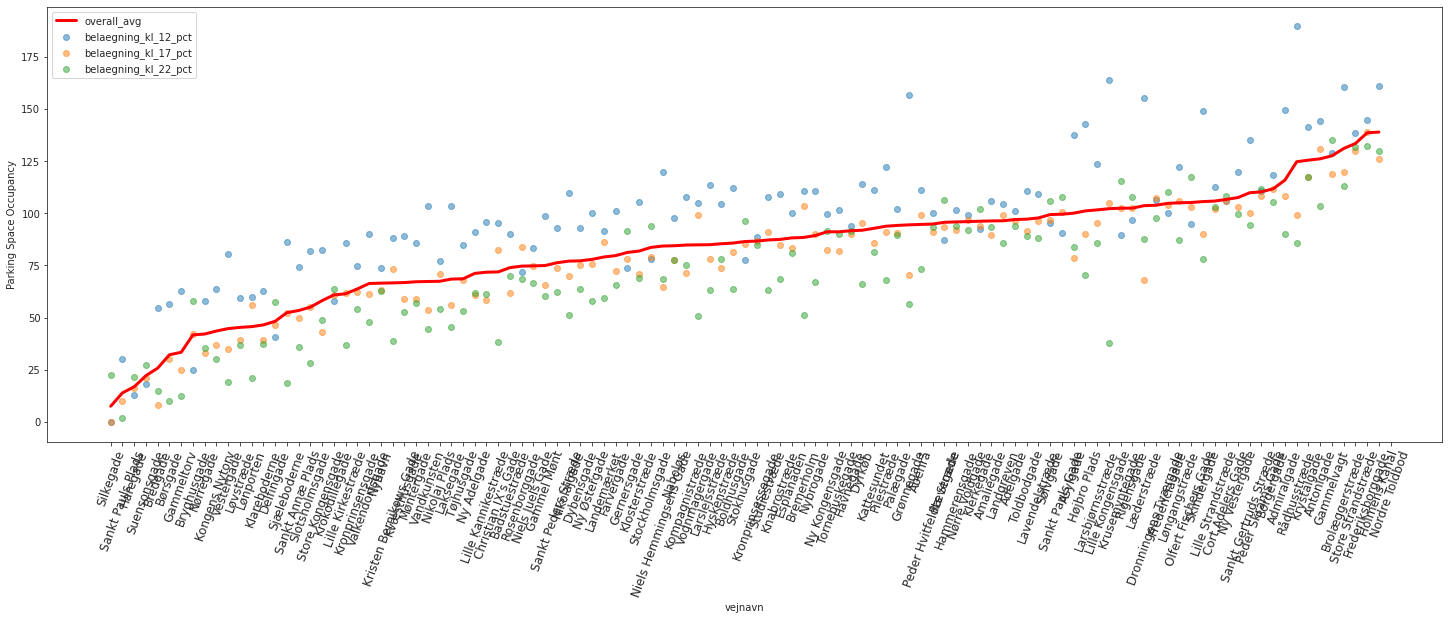

In [16]:
citycenter_df = count_new.loc[count_new['District'] == 'City_center']

# group by street name and calculate the average values for each time period
grouped = citycenter_df.groupby('vejnavn').agg({'belaegning_kl_12_pct': 'mean',
                                         'belaegning_kl_17_pct': 'mean',
                                         'belaegning_kl_22_pct': 'mean'})

grouped['overall_avg'] = grouped.mean(axis=1)
grouped = grouped.sort_values('overall_avg', ascending=True)
overall_avg = grouped[['overall_avg']]


fig, ax = plt.subplots(figsize=(25, 8))
overall_avg.plot(ax=ax, label='Overall average', lw=3, color='red')

# add scatter plots for the columns 'belaegning_kl_12_pct', 'belaegning_kl_17_pct', and 'belaegning_kl_22_pct' for each streetname(index)
for col in ['belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_22_pct']:
    ax.scatter(overall_avg.index, grouped[col], label=col, alpha=0.5)

n = 1
ax.set_xticks(range(0, len(overall_avg), n))
ax.set_xticklabels(overall_avg.index[::n], rotation=70, fontsize=12)

ax.set_ylabel('Parking Space Occupancy')
ax.legend()

plt.show()


3. To better understand the occupancy of each street at different times, we chose to visualize the data using an interactive map. We used the Python library Folium to create an interactive map that displays the street network of the city to predict the parking situation in Spring, with each street colored according to its occupancy rate.  
   To make the map interactive, we added a dropdown menu that allows the user to select the time period to display. We also added a feature that users can click on a street to view its occupancy rate.

In [17]:
#Change geographic information format
def format_geo(x):
        x = str(x)
        for i in ")(,":
            x = x.replace(i,'')
        x = x.split()[1:]
        locations = []
        for i in range(0,len(x),2):
            locations.append(x[i:i+2])
        return locations
count_new['wkb_geometry'] = count_new['wkb_geometry'].apply(format_geo)

In [18]:
spring_data = count_new[(count_new['arr_mdr'].dt.month == 3) | (count_new['arr_mdr'].dt.month == 5)]
autumn_data = count_new[count_new['arr_mdr'].dt.month == 9]
#spring_data.rename(columns={'belaegning_kl_12_pct':'belaegning_kl_12_pct_spring','belaegning_kl_17_pct':'belaegning_kl_17_pct_spring','belaegning_kl_22_pct':'belaegning_kl_22_pct_spring','wkb_geometry':'wkb_geometry_spring'})
#autumn_data.rename(columns={'belaegning_kl_12_pct':'belaegning_kl_12_pct_sutumn','belaegning_kl_17_pct':'belaegning_kl_17_pct_sutumn','belaegning_kl_22_pct':'belaegning_kl_22_pct_autumn','wkb_geometry':'wkb_geometry_autumn'})
spring_grouped = spring_data.groupby('vejnavn').agg({'vejnavn':'first',
    'belaegning_kl_12_pct': 'mean',
    'belaegning_kl_17_pct': 'mean',
    'belaegning_kl_22_pct': 'mean',
    'wkb_geometry': 'first'
})
autumn_grouped = autumn_data.groupby('vejnavn').agg({'vejnavn':'first',
    'belaegning_kl_12_pct': 'mean',
    'belaegning_kl_17_pct': 'mean',
    'belaegning_kl_22_pct': 'mean',
    'wkb_geometry': 'first'
})
spring_grouped = spring_grouped.reset_index(drop=True)

In [19]:
spring_grouped

,vejnavn,belaegning_kl_12_pct,belaegning_kl_17_pct,belaegning_kl_22_pct,wkb_geometry
0,1. Tværvej,102.000000,107.100000,109.300000,"[[12.579297419292217, 55.69758980075035], [12...."
1,A.F. Beyers Vej,82.750000,108.500000,111.500000,"[[12.514132741391071, 55.69190928302176], [12...."
2,A.F. Kriegers Vej,82.300000,91.650000,96.600000,"[[12.584327594855344, 55.702664504128116], [12..."
3,A.L. Drewsens Vej,93.350000,116.900000,129.950000,"[[12.583518678317224, 55.700905379822316], [12..."
4,Aarestrupsvej,83.300000,98.300000,100.500000,"[[12.515553234367886, 55.66174574579858], [12...."
...,...,...,...,...,...
1504,Øster Voldgade,53.300000,58.150000,50.800000,"[[12.574977899101537, 55.685444545053436], [12..."
1505,Østerbrogade,89.190476,94.678571,96.059524,"[[12.577402832587385, 55.705932565952004], [12..."
1506,Østerdalsgade,71.900000,104.100000,109.900000,"[[12.603711355829065, 55.65498922844344], [12...."
1507,Østerled,71.600000,71.400000,79.700000,"[[12.577169382494253, 55.718016567151786], [12..."


In [20]:
def create_map(column):
    cp_map = folium.Map(location=[55.678086, 12.568827], zoom_start=12)
    for i, row in spring_grouped.iterrows():
        points = []
        if len(row['wkb_geometry']) == 0:
            continue
        rate = int(row[column])
        if rate > 100:
            rate = 100
        rgb = colorsys.hsv_to_rgb((100 -rate)/ 300., 1.0, 1.0)
        color = '#%02x%02x%02x' % tuple([round(255*x) for x in rgb])
        for location in row['wkb_geometry']:
            point = []
            point.append(float(location[1]))
            point.append(float(location[0]))
            points.append(point)
        popup = row['vejnavn'] + '-' + str(rate) + '%'
        folium.PolyLine(points, color=color, popup=popup).add_to(cp_map)
    with output:
        clear_output()  
        display(cp_map)  

column_dropdown = widgets.Dropdown( # Define a dropdown widget
    options=['belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_22_pct'],
    value='belaegning_kl_12_pct',
    description='Select time:',
)

output = widgets.Output()


def dropdown_change(change):
    create_map(change.new)
    
column_dropdown.observe(dropdown_change, names='value')

display(column_dropdown)
display(output)
create_map(column_dropdown.value)


Dropdown(description='Select time:', options=('belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_2…

Output()

In [21]:
import os

def create_map(column, html_file):
    cp_map = folium.Map(location=[55.678086, 12.568827], zoom_start=12)
    for i, row in spring_grouped.iterrows():
        points = []
        if len(row['wkb_geometry']) == 0:
            continue
        rate = int(row[column])
        if rate > 100:
            rate = 100
        rgb = colorsys.hsv_to_rgb((100 -rate)/ 300., 1.0, 1.0)
        color = '#%02x%02x%02x' % tuple([round(255*x) for x in rgb])
        for location in row['wkb_geometry']:
            point = []
            point.append(float(location[1]))
            point.append(float(location[0]))
            points.append(point)
        popup = row['vejnavn'] + '-' + str(rate) + '%'
        folium.PolyLine(points, color=color, popup=popup).add_to(cp_map)
    with output:
        clear_output()  
        display(cp_map)  
    cp_map.save(html_file)

column_dropdown = widgets.Dropdown(
    options=['belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_22_pct'],
    value='belaegning_kl_12_pct',
    description='Select time:',
)

output = widgets.Output()

html_file = 'map.html' # specify the filename for the HTML file

def dropdown_change(change):
    create_map(change.new, html_file)
    
column_dropdown.observe(dropdown_change, names='value')

display(column_dropdown)
display(output)
create_map(column_dropdown.value, html_file)


Dropdown(description='Select time:', options=('belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_2…

Output()

In [22]:
import folium
import jinja2
import os
import colorsys
import pandas as pd
from IPython.display import clear_output

# Sample data: Replace this with your own data
spring_grouped = spring_grouped

def create_map(column, html_file):
    cp_map = folium.Map(location=[55.678086, 12.568827], zoom_start=12)
    for i, row in spring_grouped.iterrows():
        points = []
        if len(row['wkb_geometry']) == 0:
            continue
        rate = int(row[column])
        if rate > 100:
            rate = 100
        rgb = colorsys.hsv_to_rgb((100 - rate) / 300., 1.0, 1.0)
        color = '#%02x%02x%02x' % tuple([round(255 * x) for x in rgb])
        for location in row['wkb_geometry']:
            point = []
            point.append(float(location[1]))
            point.append(float(location[0]))
            points.append(point)
        popup = row['vejnavn'] + '-' + str(rate) + '%'
        folium.PolyLine(points, color=color, popup=popup).add_to(cp_map)
    cp_map.save(html_file)

options = ['belaegning_kl_12_pct', 'belaegning_kl_17_pct', 'belaegning_kl_22_pct']
html_file_prefix = 'map'

# Save separate maps for each time option
for option in options:
    html_file = f"{html_file_prefix}_{option}.html"
    create_map(option, html_file)

# Render the final HTML file with Jinja2
template_loader = jinja2.FileSystemLoader(searchpath="./")
template_env = jinja2.Environment(loader=template_loader)
template = template_env.get_template("map_template.html")

output_path = "map_with_dropdown.html"
with open(output_path, "w") as output_file:
    output_file.write(
        template.render(
            dropdown_options=options,
            selected_option=options[0],
            html_file=f"{html_file_prefix}_{options[0]}.html"
        )
    )


### Discussion

*   We analyzed the existing data and identified areas with inadequate parking supply. We presented the findings to the readers using interactive visualizations, allowing them to easily access the information they need and adding an element of interest to the reading experience. Through various visual presentation forms such as line graphs, heat maps, interactive maps,we gradually showcased our conclusions to the readers, greatly enhancing the readability of the article.
*   The dataset we selected only includes data for two days per year, which limits the scope of our data analysis.  With only two days of data each year, and those two days not being consecutive, we cannot accurately predict trends. In future dataset selections, we should pay more attention to whether the data contains a data structure that allows us to draw conclusions. We did not include additional data as variables in our analysis, resulting in overly narrow conclusions. In future research, we should incorporate additional data to make the conclusions more comprehensive.
